## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
!pip install tensorflow==1.14.0 keras

In [2]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: F

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:

"""Code Here
建立你的神經網路
"""
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, (use_preact, bz) in enumerate(itertools.product(PRE_ACTIVATE, BATCH_SIZE)):
    print("Numbers of exp: %i, use_preact: %s, batch_size: %i" % (i, use_preact, bz))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=use_preact)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, use_preact: True, batch_size: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activati

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



24110/50000 [=============>................] - ETA: 3:12 - loss: 2.2108 - accuracy: 0.1751

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 381s 8ms/step - loss: 2.2105 - accuracy: 0.1752 - val_loss: 2.1572 - val_accuracy: 0.1767
Epoch 14/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.2147 - accuracy: 0.1738 - val_loss: 2.1575 - val_accuracy: 0.1872
Epoch 15/50
50000/50000 [==============================] - 380s 8ms/step - loss: 2.2073 - accuracy: 0.1819 - val_loss: 2.1430 - val_accuracy: 0.1938
Epoch 16/50
50000/50000 [==============================] - 385s 8ms/step - loss: 2.2076 - accuracy: 0.1773 - val_loss: 2.1394 - val_accuracy: 0.1907
Epoch 17/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.1981 - accuracy: 0.1849 - val_loss: 2.1500 - val_accuracy: 0.1816
Epoch 18/50
50000/50000 [==============================] - 378s 8ms/step - loss: 2.2016 - accuracy: 0.1875 - val_loss: 2.1570 - val_accuracy: 0.1828
Epoch 19/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.2000 - accuracy: 0.1890 - val_loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 381s 8ms/step - loss: 2.2042 - accuracy: 0.1815 - val_loss: 2.1669 - val_accuracy: 0.1876
Epoch 34/50
 4644/50000 [=>............................] - ETA: 5:36 - loss: 2.1908 - accuracy: 0.1901

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 381s 8ms/step - loss: 2.2035 - accuracy: 0.1803 - val_loss: 2.1781 - val_accuracy: 0.1694
Epoch 35/50
50000/50000 [==============================] - 380s 8ms/step - loss: 2.2151 - accuracy: 0.1694 - val_loss: 2.2039 - val_accuracy: 0.1679
Epoch 36/50
50000/50000 [==============================] - 379s 8ms/step - loss: 2.2131 - accuracy: 0.1773 - val_loss: 2.1834 - val_accuracy: 0.1750
Epoch 37/50
50000/50000 [==============================] - 380s 8ms/step - loss: 2.2050 - accuracy: 0.1856 - val_loss: 2.2072 - val_accuracy: 0.1564
Epoch 38/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.1984 - accuracy: 0.1875 - val_loss: 2.1738 - val_accuracy: 0.1791
Epoch 39/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.2011 - accuracy: 0.1869 - val_loss: 2.1804 - val_accuracy: 0.1759
Epoch 40/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2018 - accuracy: 0.1852 - val_loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 381s 8ms/step - loss: 2.2194 - accuracy: 0.1715 - val_loss: 2.1995 - val_accuracy: 0.1562
Epoch 50/50
17706/50000 [=========>....................] - ETA: 3:59 - loss: 2.2166 - accuracy: 0.1788

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 380s 8ms/step - loss: 2.2142 - accuracy: 0.1795 - val_loss: 2.1735 - val_accuracy: 0.1752
Numbers of exp: 1, use_preact: True, batch_size: 16
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
ba

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 50s 1ms/step - loss: 1.2777 - accuracy: 0.5464 - val_loss: 1.3947 - val_accuracy: 0.5040
Epoch 7/50
50000/50000 [==============================] - 49s 990us/step - loss: 1.2378 - accuracy: 0.5616 - val_loss: 1.3271 - val_accuracy: 0.5256
Epoch 8/50
50000/50000 [==============================] - 49s 990us/step - loss: 1.1888 - accuracy: 0.5779 - val_loss: 1.3968 - val_accuracy: 0.5119
Epoch 9/50
50000/50000 [==============================] - 49s 990us/step - loss: 1.1547 - accuracy: 0.5904 - val_loss: 1.4906 - val_accuracy: 0.4834
Epoch 10/50
50000/50000 [==============================] - 49s 986us/step - loss: 1.1147 - accuracy: 0.6039 - val_loss: 1.3510 - val_accuracy: 0.5274
Epoch 11/50
50000/50000 [==============================] - 50s 993us/step - loss: 1.0835 - accuracy: 0.6124 - val_loss: 1.3088 - val_accuracy: 0.5386
Epoch 12/50
50000/50000 [==============================] - 50s 993us/step - loss: 1.0456 - accuracy: 0.6264 - val_los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 382s 8ms/step - loss: 2.2174 - accuracy: 0.1754 - val_loss: 98.5616 - val_accuracy: 0.2384
Epoch 6/50
14582/50000 [=======>......................] - ETA: 4:25 - loss: 2.2199 - accuracy: 0.1734

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 381s 8ms/step - loss: 2.2185 - accuracy: 0.1755 - val_loss: 188.9412 - val_accuracy: 0.2418
Epoch 7/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2156 - accuracy: 0.1762 - val_loss: 37.9731 - val_accuracy: 0.2046
Epoch 8/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2174 - accuracy: 0.1758 - val_loss: 79.0908 - val_accuracy: 0.2396
Epoch 9/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2141 - accuracy: 0.1758 - val_loss: 20.9861 - val_accuracy: 0.2302
Epoch 10/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2104 - accuracy: 0.1780 - val_loss: 84.5877 - val_accuracy: 0.2185
Epoch 11/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.2059 - accuracy: 0.1791 - val_loss: 29.4361 - val_accuracy: 0.2407
Epoch 12/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.2033 - accuracy: 0.1829 - val_l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



48922/50000 [============================>.] - ETA: 8s - loss: 2.2107 - accuracy: 0.1803

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 381s 8ms/step - loss: 2.2131 - accuracy: 0.1755 - val_loss: 67.3976 - val_accuracy: 0.2108
Epoch 24/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2142 - accuracy: 0.1802 - val_loss: 180.5849 - val_accuracy: 0.2220
Epoch 25/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2093 - accuracy: 0.1779 - val_loss: 113.2883 - val_accuracy: 0.2384
Epoch 26/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2122 - accuracy: 0.1776 - val_loss: 83.6341 - val_accuracy: 0.2363
Epoch 27/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2144 - accuracy: 0.1769 - val_loss: 112.2865 - val_accuracy: 0.2188
Epoch 28/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.2057 - accuracy: 0.1813 - val_loss: 116.7016 - val_accuracy: 0.2328
Epoch 29/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2082 - accuracy: 0.1798 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



40382/50000 [=======================>......] - ETA: 1:12 - loss: 2.2082 - accuracy: 0.1831

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 381s 8ms/step - loss: 2.2061 - accuracy: 0.1801 - val_loss: 60.5648 - val_accuracy: 0.2385
Epoch 41/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2039 - accuracy: 0.1842 - val_loss: 271.2223 - val_accuracy: 0.2385
Epoch 42/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.2085 - accuracy: 0.1815 - val_loss: 124.7718 - val_accuracy: 0.2382
Epoch 43/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.2078 - accuracy: 0.1821 - val_loss: 85.4205 - val_accuracy: 0.2518
Epoch 44/50
50000/50000 [==============================] - 382s 8ms/step - loss: 2.2047 - accuracy: 0.1836 - val_loss: 329.1960 - val_accuracy: 0.2447
Epoch 45/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.2080 - accuracy: 0.1818 - val_loss: 194.7374 - val_accuracy: 0.2382
Epoch 46/50
50000/50000 [==============================] - 381s 8ms/step - loss: 2.2106 - accuracy: 0.1796 -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 50s 998us/step - loss: 1.4740 - accuracy: 0.4759 - val_loss: 1.4675 - val_accuracy: 0.4740
Epoch 8/50
50000/50000 [==============================] - 50s 1ms/step - loss: 1.4358 - accuracy: 0.4913 - val_loss: 1.5068 - val_accuracy: 0.4723
Epoch 10/50
50000/50000 [==============================] - 49s 990us/step - loss: 1.4313 - accuracy: 0.4899 - val_loss: 1.4882 - val_accuracy: 0.4746
Epoch 11/50
50000/50000 [==============================] - 50s 996us/step - loss: 1.4071 - accuracy: 0.4978 - val_loss: 1.4485 - val_accuracy: 0.4880
Epoch 12/50
50000/50000 [==============================] - 50s 994us/step - loss: 1.3932 - accuracy: 0.5067 - val_loss: 1.4607 - val_accuracy: 0.4918
Epoch 13/50
25056/50000 [==============>...............] - ETA: 24s - loss: 1.3747 - accuracy: 0.5080

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



50000/50000 [==============================] - 50s 992us/step - loss: 1.3578 - accuracy: 0.5176 - val_loss: 1.3808 - val_accuracy: 0.5096
Epoch 17/50
50000/50000 [==============================] - 50s 999us/step - loss: 1.3434 - accuracy: 0.5229 - val_loss: 1.4500 - val_accuracy: 0.4869
Epoch 18/50
50000/50000 [==============================] - 49s 988us/step - loss: 1.3321 - accuracy: 0.5273 - val_loss: 1.3879 - val_accuracy: 0.5087
Epoch 19/50
50000/50000 [==============================] - 50s 999us/step - loss: 1.3234 - accuracy: 0.5291 - val_loss: 1.3963 - val_accuracy: 0.5128
Epoch 20/50
50000/50000 [==============================] - 50s 994us/step - loss: 1.3148 - accuracy: 0.5322 - val_loss: 1.3756 - val_accuracy: 0.5134
Epoch 21/50
50000/50000 [==============================] - 50s 1ms/step - loss: 1.3040 - accuracy: 0.5351 - val_loss: 1.3880 - val_accuracy: 0.5101
Epoch 22/50
50000/50000 [==============================] - 50s 997us/step - loss: 1.2952 - accuracy: 0.5424 - val_

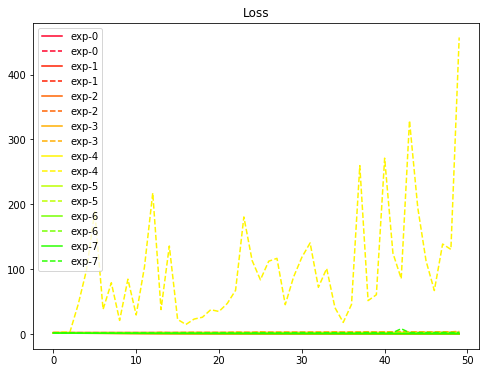

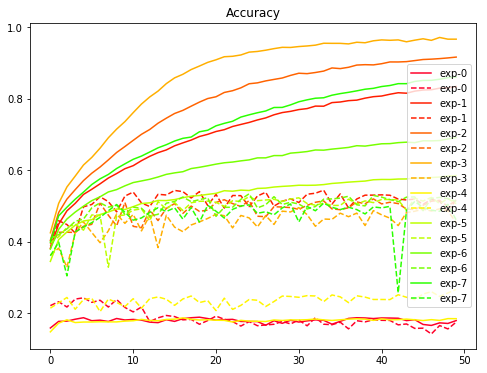

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()